In [4]:
# our basic libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size=20

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN
data_transform = transforms.ToTensor()

# Download and load the training data
trainset = FashionMNIST('F_MNIST_data/', download=True, train=True, transform=data_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = FashionMNIST('F_MNIST_data/', download=True, train=False, transform=data_transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

Train data, number of images:  60000
Test data, number of images:  10000


In [17]:
images, labels = next(iter(trainloader))
images.size()

torch.Size([20, 1, 28, 28])

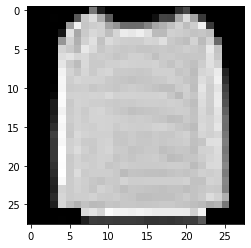

In [18]:
plt.imshow(images[1].numpy().squeeze(), cmap='gray')

In [7]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # from (1, 28, 28) to (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting
        # from (10, 26, 26) to (10, 13, 13)
        # from (20, 11, 11) to (20, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        # from (10, 13, 13) to (20, 11, 11)
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        
        # from (20, 5, 5) to (10)
        self.fc1 = nn.Linear(20*5*5, 10)
        

    ## TODO: define the feedforward behavior
    def forward(self, x):
        # one activated conv layer
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # one linear layer
        x = F.relu(self.fc1(x))
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        
        # final output
        return x


# instantiate and print your Net
model = Model()
print(model)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


In [8]:
# cross entropy loss combines softmax and nn.NLLLoss() in one single class.
criterion = nn.NLLLoss()

# stochastic gradient descent with a small learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [21]:


def train(n_epochs):
    loss_over_time = []
    
    # move model to GPU
    #model.to("cuda")

    for epoch in range(n_epochs):
        running_loss = 0.0
        batch_i = 0
        for images, labels in iter(trainloader):
            
            # move images and label tensors to GPU
            #images = images.to("cuda")
            #labels = labels.to("cuda")
            
            
            #zero the weight gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            outputs = model(images)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            
            # backward pass to calculate the parameter gradients
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            epoch_loss = loss.item()
            batch_i+=batch_size
            
            running_loss += loss.item()
            if batch_i%20000 == 0:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i, avg_loss))
                running_loss = 0.0
            
                
#         loss_over_time.append(epoch_loss)      
#         print("Epoch: {}, Loss: {}".format(epoch+1, epoch_loss))
                
    print("Finished training")
    return loss_over_time
                
            
        
    

In [22]:
n_epochs = 5


training_loss = train(n_epochs)

Epoch: 1, Batch: 20000, Avg. Loss: 2.24786385178566
Epoch: 1, Batch: 40000, Avg. Loss: 1.993544463992119
Epoch: 1, Batch: 60000, Avg. Loss: 1.589820218503475
Epoch: 2, Batch: 20000, Avg. Loss: 1.4087335712313651
Epoch: 2, Batch: 40000, Avg. Loss: 1.2983681752085685
Epoch: 2, Batch: 60000, Avg. Loss: 1.2443346768021584
Epoch: 3, Batch: 20000, Avg. Loss: 1.201779434144497
Epoch: 3, Batch: 40000, Avg. Loss: 1.1901785299181937
Epoch: 3, Batch: 60000, Avg. Loss: 1.1735770249962807
Epoch: 4, Batch: 20000, Avg. Loss: 1.156689530134201
Epoch: 4, Batch: 40000, Avg. Loss: 1.1267522166967392
Epoch: 4, Batch: 60000, Avg. Loss: 1.1235617685317993
Epoch: 5, Batch: 20000, Avg. Loss: 1.1128305925130844
Epoch: 5, Batch: 40000, Avg. Loss: 1.084244221240282
Epoch: 5, Batch: 60000, Avg. Loss: 1.0962794167101384
Finished training


In [67]:
999%1000


999

In [9]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    # move model to GPU
    #model.to("cuda")
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(trainloader):
            # get the input images and their corresponding labels
            inputs, labels = data
            
            # move images and label tensors to GPU
            #inputs = inputs.to("cuda")
            #labels = labels.to("cuda")

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [10]:
n_epochs = 5


training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 2.291698361158371
Epoch: 1, Batch: 2000, Avg. Loss: 2.255459939479828
Epoch: 1, Batch: 3000, Avg. Loss: 2.118408938884735
Epoch: 2, Batch: 1000, Avg. Loss: 1.7161077836751937
Epoch: 2, Batch: 2000, Avg. Loss: 1.4990334876775742
Epoch: 2, Batch: 3000, Avg. Loss: 1.3907651245594024
Epoch: 3, Batch: 1000, Avg. Loss: 1.2120998161435128
Epoch: 3, Batch: 2000, Avg. Loss: 1.1009270148277284
Epoch: 3, Batch: 3000, Avg. Loss: 1.03816006731987
Epoch: 4, Batch: 1000, Avg. Loss: 0.9974813283085823
Epoch: 4, Batch: 2000, Avg. Loss: 0.9945689930021763
Epoch: 4, Batch: 3000, Avg. Loss: 0.9704925980567932
Epoch: 5, Batch: 1000, Avg. Loss: 0.951262921333313
Epoch: 5, Batch: 2000, Avg. Loss: 0.9260910192728042
Epoch: 5, Batch: 3000, Avg. Loss: 0.9278217017352581
Finished Training


In [23]:
torch.cuda.is_available()

True

In [24]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070 with Max-Q Design'

In [7]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))

model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [27]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        # because output is log(softmax), so taking exp returns softmax
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [29]:
epochs = 3
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    model.train()
    for images, labels in iter(trainloader):
        
        steps += 1
        images.resize_(images.size()[0], 784)
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            # no dropouts
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/3..  Training Loss: 0.557..  Test Loss: 0.585..  Test Accuracy: 0.797
Epoch: 1/3..  Training Loss: 0.578..  Test Loss: 0.598..  Test Accuracy: 0.791
Epoch: 1/3..  Training Loss: 0.591..  Test Loss: 0.578..  Test Accuracy: 0.796
Epoch: 1/3..  Training Loss: 0.552..  Test Loss: 0.598..  Test Accuracy: 0.790
Epoch: 1/3..  Training Loss: 0.548..  Test Loss: 0.605..  Test Accuracy: 0.787
Epoch: 1/3..  Training Loss: 0.544..  Test Loss: 0.571..  Test Accuracy: 0.802
Epoch: 1/3..  Training Loss: 0.541..  Test Loss: 0.573..  Test Accuracy: 0.800
Epoch: 1/3..  Training Loss: 0.549..  Test Loss: 0.566..  Test Accuracy: 0.804
Epoch: 1/3..  Training Loss: 0.554..  Test Loss: 0.569..  Test Accuracy: 0.805
Epoch: 1/3..  Training Loss: 0.544..  Test Loss: 0.578..  Test Accuracy: 0.796
Epoch: 1/3..  Training Loss: 0.558..  Test Loss: 0.565..  Test Accuracy: 0.803
Epoch: 1/3..  Training Loss: 0.539..  Test Loss: 0.560..  Test Accuracy: 0.807
Epoch: 1/3..  Training Loss: 0.531..  Test Loss: 0.5

In [33]:
# to avoid having dropout when doing validation
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities


tensor([[7.4575e+00, 1.3439e+01, 2.0471e+00, 4.4669e+02, 1.5529e+00, 1.5067e-02,
         8.1384e-01, 4.0921e-02, 2.4455e-01, 9.1974e-02]])

In [36]:
labels[0]

tensor(3)